### New experiments

In [779]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing as pre
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.base import TransformerMixin

from sklearn_pandas import DataFrameMapper, CategoricalImputer

In [3]:
plt.style.use('ggplot')
plt.rc('figure', dpi=90)

In [111]:
data = pd.read_csv('train.csv', index_col=0)

In [815]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [113]:
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [595]:
class NotNa(TransformerMixin):
    def transform(self, X, y=None, **transform_args):
        df = pd.DataFrame(X)
        return df.notna()
    
    def fit(self, X, y=None, **fit_params):
        pass

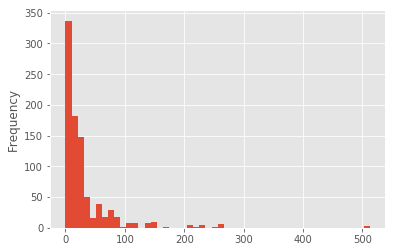

In [731]:
data.Fare.plot.hist(bins=50)

Drop the three passengers that payed more than 500.

In [732]:
data[data.Fare == data.Fare.max()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [733]:
no_rich = data.drop(data[data.Fare == data.Fare.max()].index)

In [758]:
X = no_rich.drop('Survived', axis=1)
y = no_rich.Survived

In [778]:
transformations = [
    (['Pclass'], pre.LabelBinarizer()),
    (['Sex'], pre.LabelBinarizer()),
    (['Fare'], [pre.Imputer(strategy='mean'), pre.Normalizer(), pre.StandardScaler()]),
    ('Cabin', NotNa()),
    ('Embarked', [CategoricalImputer(), pre.LabelBinarizer()]),
]

mapper = DataFrameMapper(transformations, df_out=True)
algorithms = [('random forest', RandomForestClassifier()), 
              ('svc', SVC()), 
              ('knn', KNeighborsClassifier())]

for name, algorithm in algorithms:
    pipe = make_pipeline(mapper, algorithm)
    precision = cross_val_score(pipe, X, y, cv=5, scoring='precision').mean()
    print(f'{name}: {precision}')

random forest: 0.8391006874535197
svc: 0.7407576112353214
knn: 0.8906502184165855


In [806]:
pipe = Pipeline([('mapper', mapper),
                 ('model', KNeighborsClassifier())])

param_grid = [{'model__n_neighbors': [4, 5, 7, 10],
               'model__weights': ['uniform', 'distance'],
               'model__algorithm': ['ball_tree', 'kd_tree', 'auto'],
               'model__leaf_size': [30, 50, 60]}]

grid = GridSearchCV(pipe, cv=5, n_jobs=2, param_grid=param_grid, scoring='precision')
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=True,
        features=[(['Pclass'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), (['Sex'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), (['Fare'], [Imputer(axis=0, copy=True, missing_values='NaN', strategy...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'model__n_neighbors': [4, 5, 7, 10], 'model__weights': ['uniform', 'distance'], 'model__algorithm': ['ball_tree', 'kd_tree', 'auto'], 'model__leaf_size': [30, 50, 60]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [807]:
grid.best_score_

0.9074017506519584

In [808]:
grid.best_params_

{'model__algorithm': 'ball_tree',
 'model__leaf_size': 30,
 'model__n_neighbors': 4,
 'model__weights': 'uniform'}

### Submission 2

In [817]:
test_data = pd.read_csv('test.csv', index_col=0)

In [818]:
test_data.sample(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1100,1,"Rosenbaum, Miss. Edith Louise",female,33.0,0,0,PC 17613,27.7208,A11,C
938,1,"Chevre, Mr. Paul Romaine",male,45.0,0,0,PC 17594,29.7000,A9,C
1038,1,"Hilliard, Mr. Herbert Henry",male,NaN,0,0,17463,51.8625,E46,S


In [816]:
predictions = grid.predict(test_data)
submission = pd.DataFrame({'Survived': predictions}, index=test_data.index)
submission.head()

TypeError: predict() got an unexpected keyword argument 'index_col'

In [814]:
submission

,Survived
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,0
9,0
